In [1]:
!pip install labelme 

In [1]:
import os
import time
import uuid
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 120

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('Gyr', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [6]:
!labelme

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [3]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [6]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [7]:
type(images)

NameError: name 'images' is not defined

In [4]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [5]:
plot_images = image_generator.next()

NameError: name 'image_generator' is not defined

NameError: name 'plot_images' is not defined

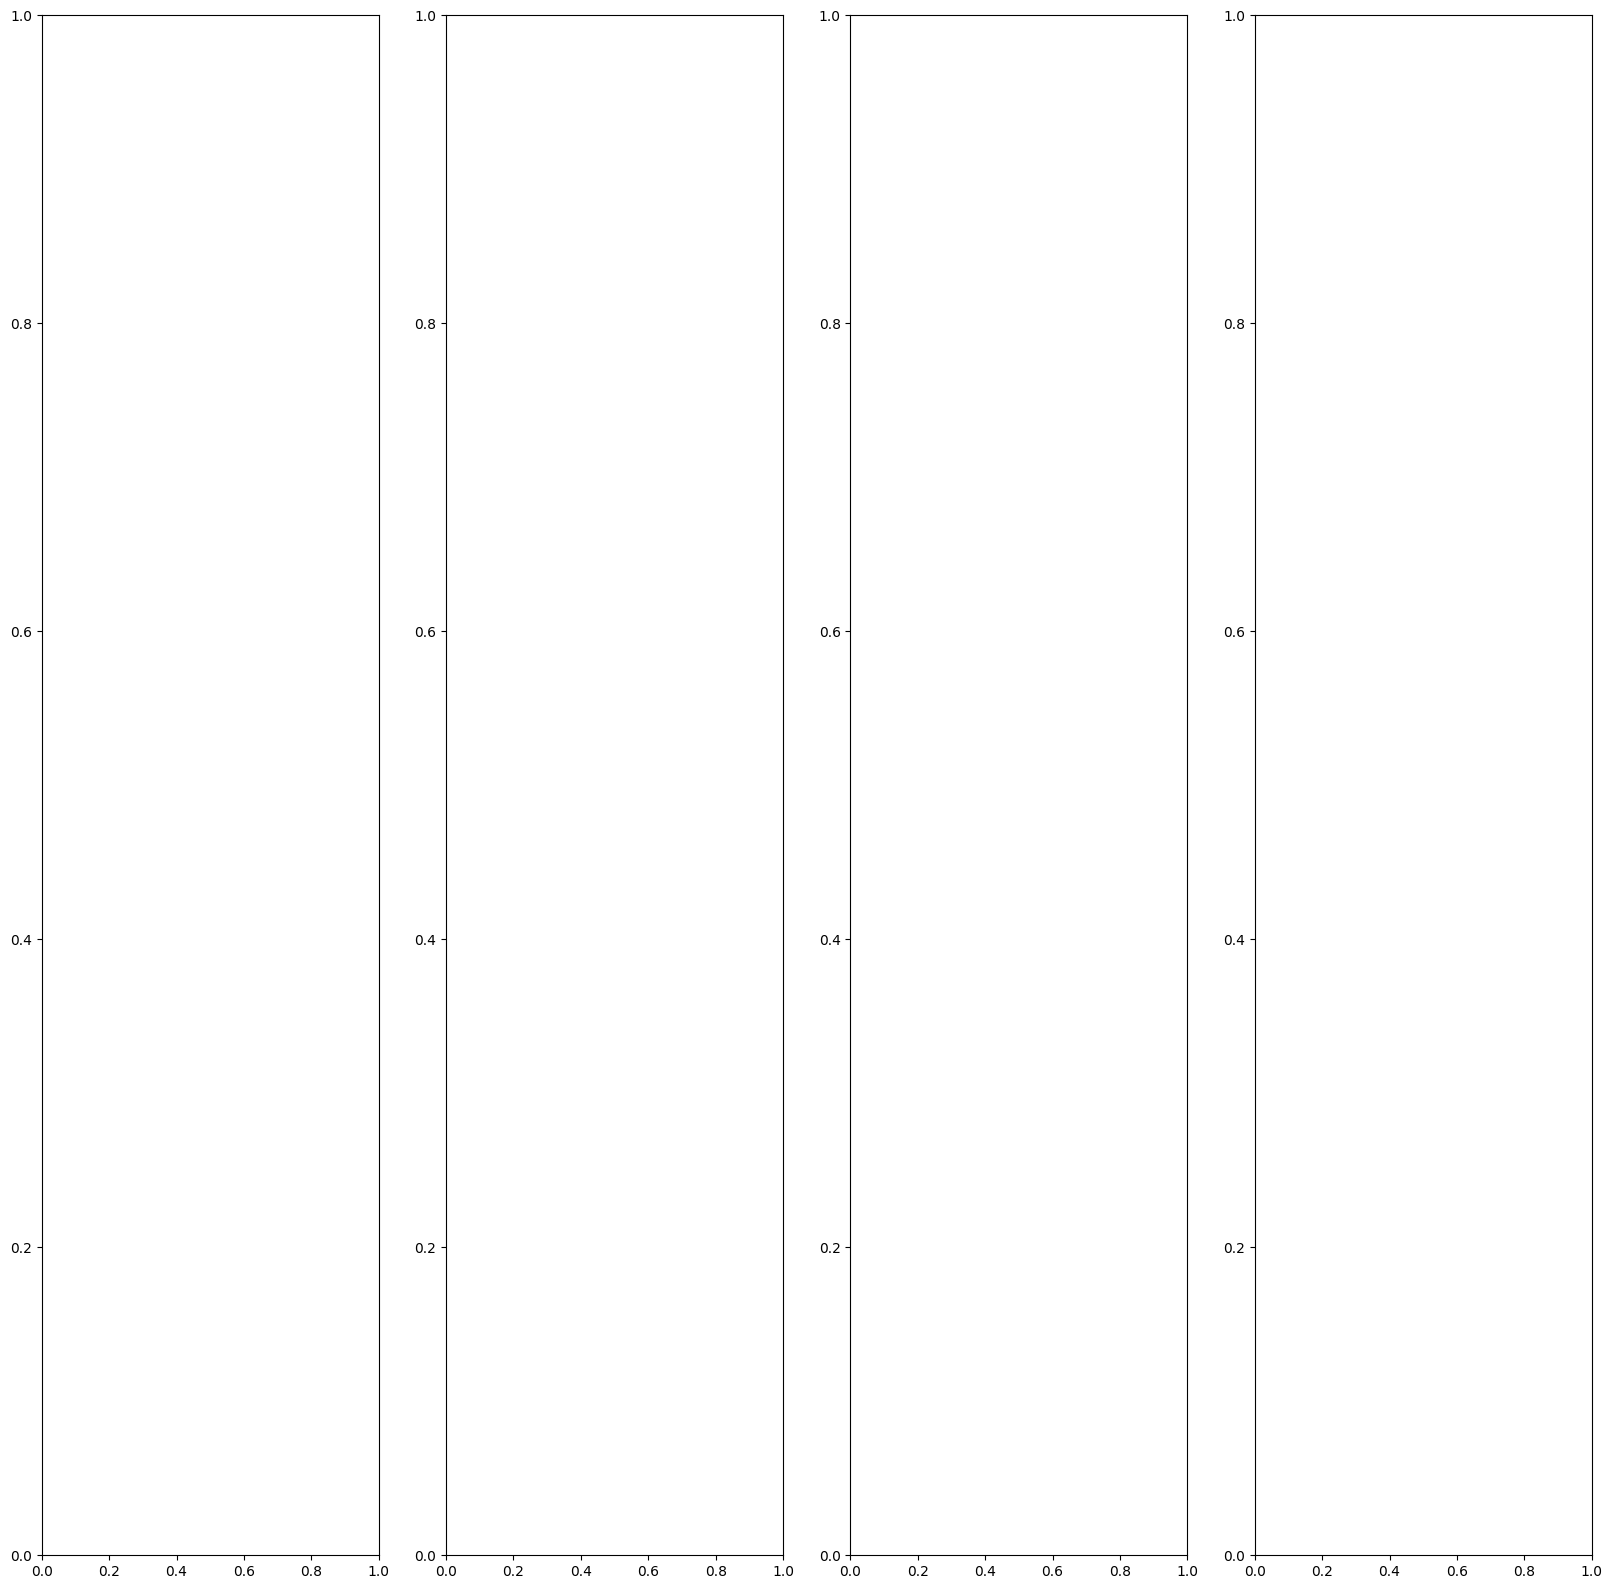

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

3. Partition Unaugmented Data

3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

# 3.2 Move the Matching Labels

In [9]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

4.1 Setup Albumentations Transform Pipeline

In [10]:
import albumentations as alb

In [11]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

4.2 Load a Test Image and Annotation with OpenCV and JSON

In [12]:
img = cv2.imread(os.path.join('data','train', 'images','4df8b10c-ff09-11ed-923e-04cf4b415632.jpg'))

In [13]:
with open(os.path.join('data', 'train', 'labels', '4df8b10c-ff09-11ed-923e-04cf4b415632.json'), 'r') as f:
    label = json.load(f)

In [14]:
label['shapes'][0]['points']

[[268.98477157360406, 150.15228426395942],
 [422.28426395939084, 370.9644670050762]]

4.3 Extract Coordinates and Rescale to Match Image Resolution

In [15]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [16]:
coords

[268.98477157360406, 150.15228426395942, 422.28426395939084, 370.9644670050762]

In [17]:
coords = list(np.divide(coords, [640,480,640,480]))

In [18]:
coords

[0.42028870558375636,
 0.3128172588832488,
 0.6598191624365481,
 0.7728426395939088]

4.4 Apply Augmentations and View Results

In [19]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Umut'])

In [20]:
augmented['bboxes'][0][2:]

(0.9361872532430907, 0.7307727016356458)

In [21]:
augmented['bboxes']

[(0.5955217146080091,
  0.24007896221094183,
  0.9361872532430907,
  0.7307727016356458)]

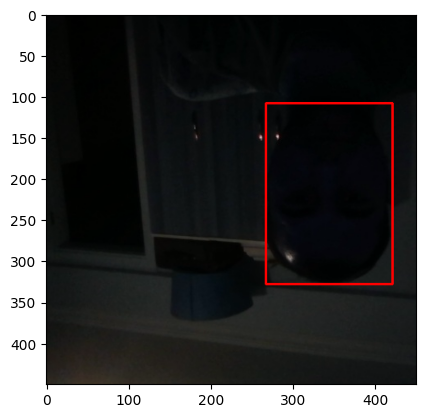

In [22]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [21]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.890625, 0.4217428087986464, 0.6391973350253808, 0.8035109983079527, 'face'].


5.2 Load Augmented Images to Tensorflow Dataset

In [23]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [24]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [25]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [26]:
train_images.as_numpy_iterator().next()

array([[[0.06905637, 0.07634804, 0.05490196],
        [0.06746323, 0.0713848 , 0.04001226],
        [0.07352941, 0.07647059, 0.0314951 ],
        ...,
        [0.23088235, 0.27009803, 0.30539215],
        [0.21292892, 0.2521446 , 0.2908701 ],
        [0.20490196, 0.2485294 , 0.28382352]],

       [[0.07322304, 0.07273284, 0.06452206],
        [0.06709559, 0.07101715, 0.05091912],
        [0.06623775, 0.07015932, 0.0466299 ],
        ...,
        [0.20729166, 0.24650735, 0.28180146],
        [0.19166666, 0.23088235, 0.26917893],
        [0.19368872, 0.2367647 , 0.2720588 ]],

       [[0.0776348 , 0.07371324, 0.05410539],
        [0.07009804, 0.07401961, 0.0504902 ],
        [0.06660539, 0.07052696, 0.04699755],
        ...,
        [0.18958333, 0.22879902, 0.2680147 ],
        [0.1860907 , 0.22530638, 0.26452205],
        [0.18125   , 0.22046569, 0.2572304 ]],

       ...,

       [[0.00784314, 0.00784314, 0.        ],
        [0.00398284, 0.00398284, 0.        ],
        [0.00784314, 0

# 6. Prepare Labels

6.1 Build Label Loading Function

In [27]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

6.2 Load Labels to Tensorflow Dataset

In [28]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.07495, 0.3337 , 0.4155 , 0.824  ], dtype=float16))

# 7. Combine Label and Image Samples

7.1 Check Partition Lengths

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(10080, 10080, 2340, 2340, 1920, 1920)

7.2 Create Final Datasets (Images/Labels)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [36]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.0702, 0.2334, 0.3916, 0.617 ],
        [0.3826, 0.3872, 0.7344, 0.834 ],
        [0.227 , 0.    , 0.6626, 0.579 ],
        [0.548 , 0.4387, 0.9224, 0.941 ],
        [0.3105, 0.318 , 0.6514, 0.8086],
        [0.1254, 0.4094, 0.4255, 0.7524],
        [0.2301, 0.287 , 0.5854, 0.7314],
        [0.2416, 0.4116, 0.564 , 0.812 ]], dtype=float16))

7.3 View Images and Annotations

In [37]:
data_samples = train.as_numpy_iterator()

In [38]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


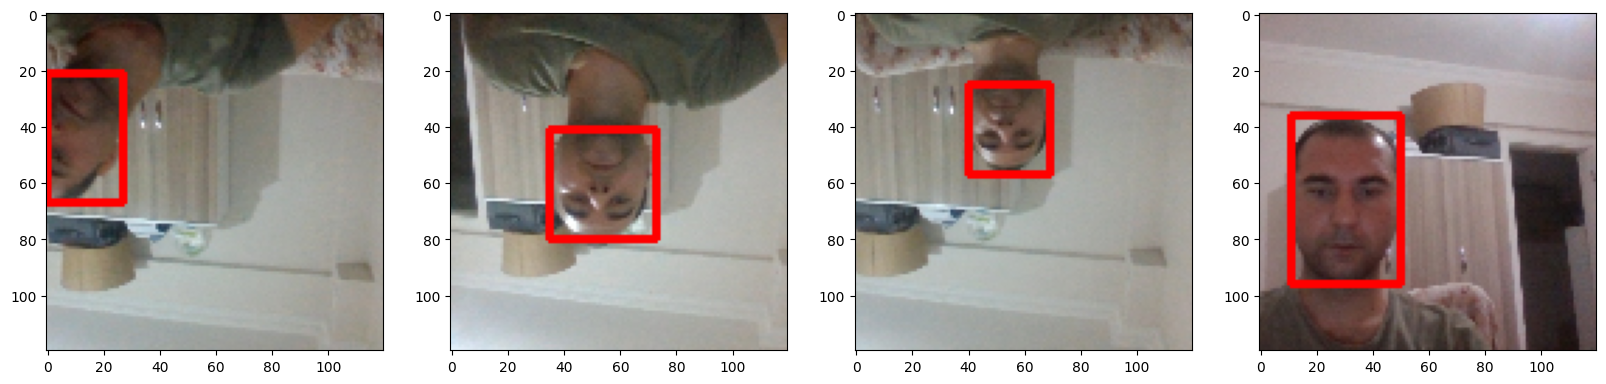

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)



# 8. Build Deep Learning using the Functional API

8.1 Import Layers and Base Network

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

8.2 Download VGG16

In [41]:
vgg = VGG16(include_top=False)

In [42]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

8.3 Build instance of Network

In [43]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

8.4 Test out Neural Network

In [44]:
facetracker = build_model()

In [45]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [46]:
X, y = train.as_numpy_iterator().next()

In [47]:
X.shape

(8, 120, 120, 3)

In [48]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 316ms/step


In [49]:
classes, coords

(array([[0.58065057],
        [0.58878624],
        [0.54366094],
        [0.508131  ],
        [0.5516919 ],
        [0.609039  ],
        [0.5399246 ],
        [0.50942266]], dtype=float32),
 array([[0.7603147 , 0.15217794, 0.3229213 , 0.25017956],
        [0.66633844, 0.20193352, 0.35954142, 0.36134005],
        [0.7115813 , 0.2294827 , 0.32609478, 0.29582018],
        [0.72039574, 0.24848028, 0.28872013, 0.28800425],
        [0.71460897, 0.2440971 , 0.37815738, 0.26857397],
        [0.7316465 , 0.23259789, 0.3698618 , 0.26486737],
        [0.71989894, 0.22800915, 0.38541573, 0.281224  ],
        [0.6839184 , 0.21905027, 0.35026678, 0.28223014]], dtype=float32))

# 9. Define Losses and Optimizers

9.1 Define Optimizer and LR

In [50]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [51]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

9.2 Create Localization Loss and Classification Loss

In [52]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [53]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

9.3 Test out Loss Metrics

In [54]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1901236>

In [55]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5926479>

In [56]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1901236>

# 10. Train Neural Network

10.1 Create Custom Model Class

In [57]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [58]:
model = FaceTracker(facetracker)

In [59]:
model.compile(opt, classloss, regressloss)

10.2 Train

In [60]:
logdir='logs'

In [61]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [63]:
tf.config.list_physical_devices('GPU')

[]

In [64]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [65]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
1260/1260 [==============================] - 1315s 1s/step - total_loss: 0.2843 - class_loss: 0.0621 - regress_loss: 0.2532 - val_total_loss: 0.8507 - val_class_loss: 0.5801 - val_regress_loss: 0.5606
Epoch 2/10
1260/1260 [==============================] - 1331s 1s/step - total_loss: 0.0750 - class_loss: 0.0176 - regress_loss: 0.0662 - val_total_loss: 0.1776 - val_class_loss: 0.0490 - val_regress_loss: 0.1531
Epoch 3/10
1260/1260 [==============================] - 1357s 1s/step - total_loss: 0.0732 - class_loss: 0.0189 - regress_loss: 0.0637 - val_total_loss: 0.0643 - val_class_loss: 0.0203 - val_regress_loss: 0.0542
Epoch 4/10
1260/1260 [==============================] - 1391s 1s/step - total_loss: 0.0324 - class_loss: 0.0095 - regress_loss: 0.0276 - val_total_loss: 0.9036 - val_class_loss: 0.6298 - val_regress_loss: 0.5887
Epoch 5/10
1260/1260 [==============================] - 1421s 1s/step - total_loss: 0.0677 - class_loss: 0.0179 - regress_loss: 0.0588 - val_total_loss:

In [66]:
hist.history

{'total_loss': [0.04412027448415756,
  0.032314371317625046,
  0.017700834199786186,
  0.017749350517988205,
  0.026929106563329697,
  0.011201493442058563,
  0.00934816338121891,
  0.009337488561868668,
  0.0962328240275383,
  0.007773819379508495],
 'class_loss': [0.00017122992721851915,
  0.0005563604645431042,
  0.0007200263789854944,
  0.0002585769980214536,
  0.003121541813015938,
  0.0036932574585080147,
  9.387744057676173e-07,
  9.574167961545754e-06,
  0.004274745937436819,
  0.00051731220446527],
 'regress_loss': [0.04403465986251831,
  0.032036192715168,
  0.017340820282697678,
  0.017620062455534935,
  0.025368336588144302,
  0.009354865178465843,
  0.009347693994641304,
  0.009332701563835144,
  0.09409545361995697,
  0.0075151631608605385],
 'val_total_loss': [0.8506643772125244,
  0.17763511836528778,
  0.06433980911970139,
  0.9035669565200806,
  0.43853408098220825,
  3.0545830726623535,
  0.7874073386192322,
  0.8880144357681274,
  0.0363127775490284,
  0.84994381666

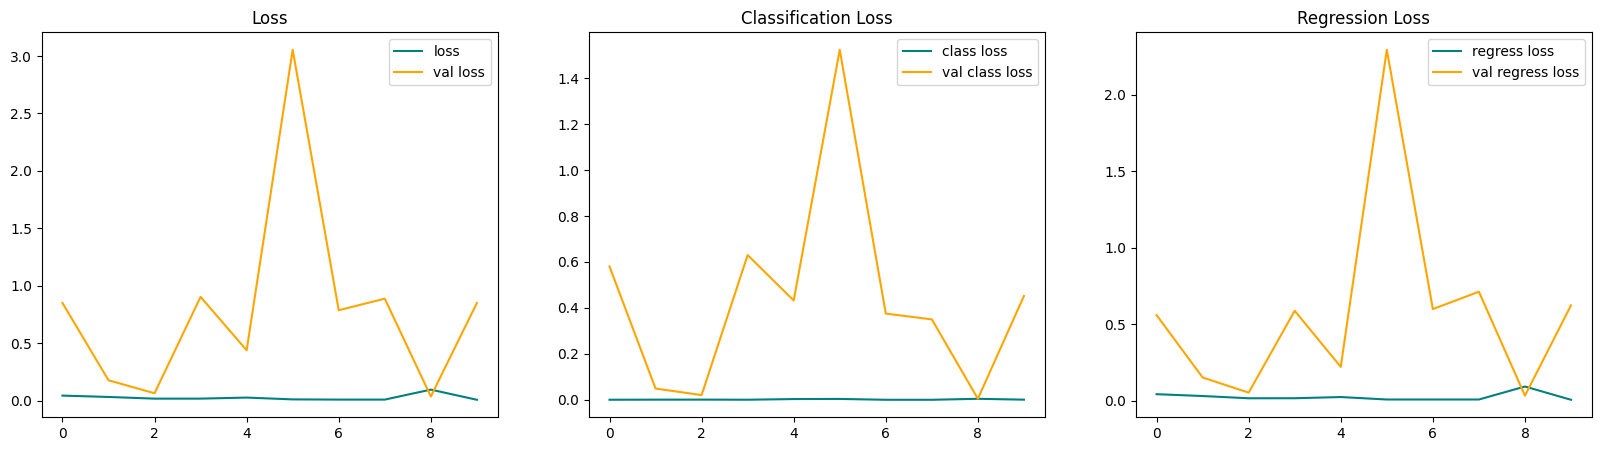

In [67]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

11.1 Make Predictions on Test Set

In [75]:
test_data = test.as_numpy_iterator()

In [77]:
test_sample = test_data.next()

In [78]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 279ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 1 is out of bounds for axis 0 with size 1

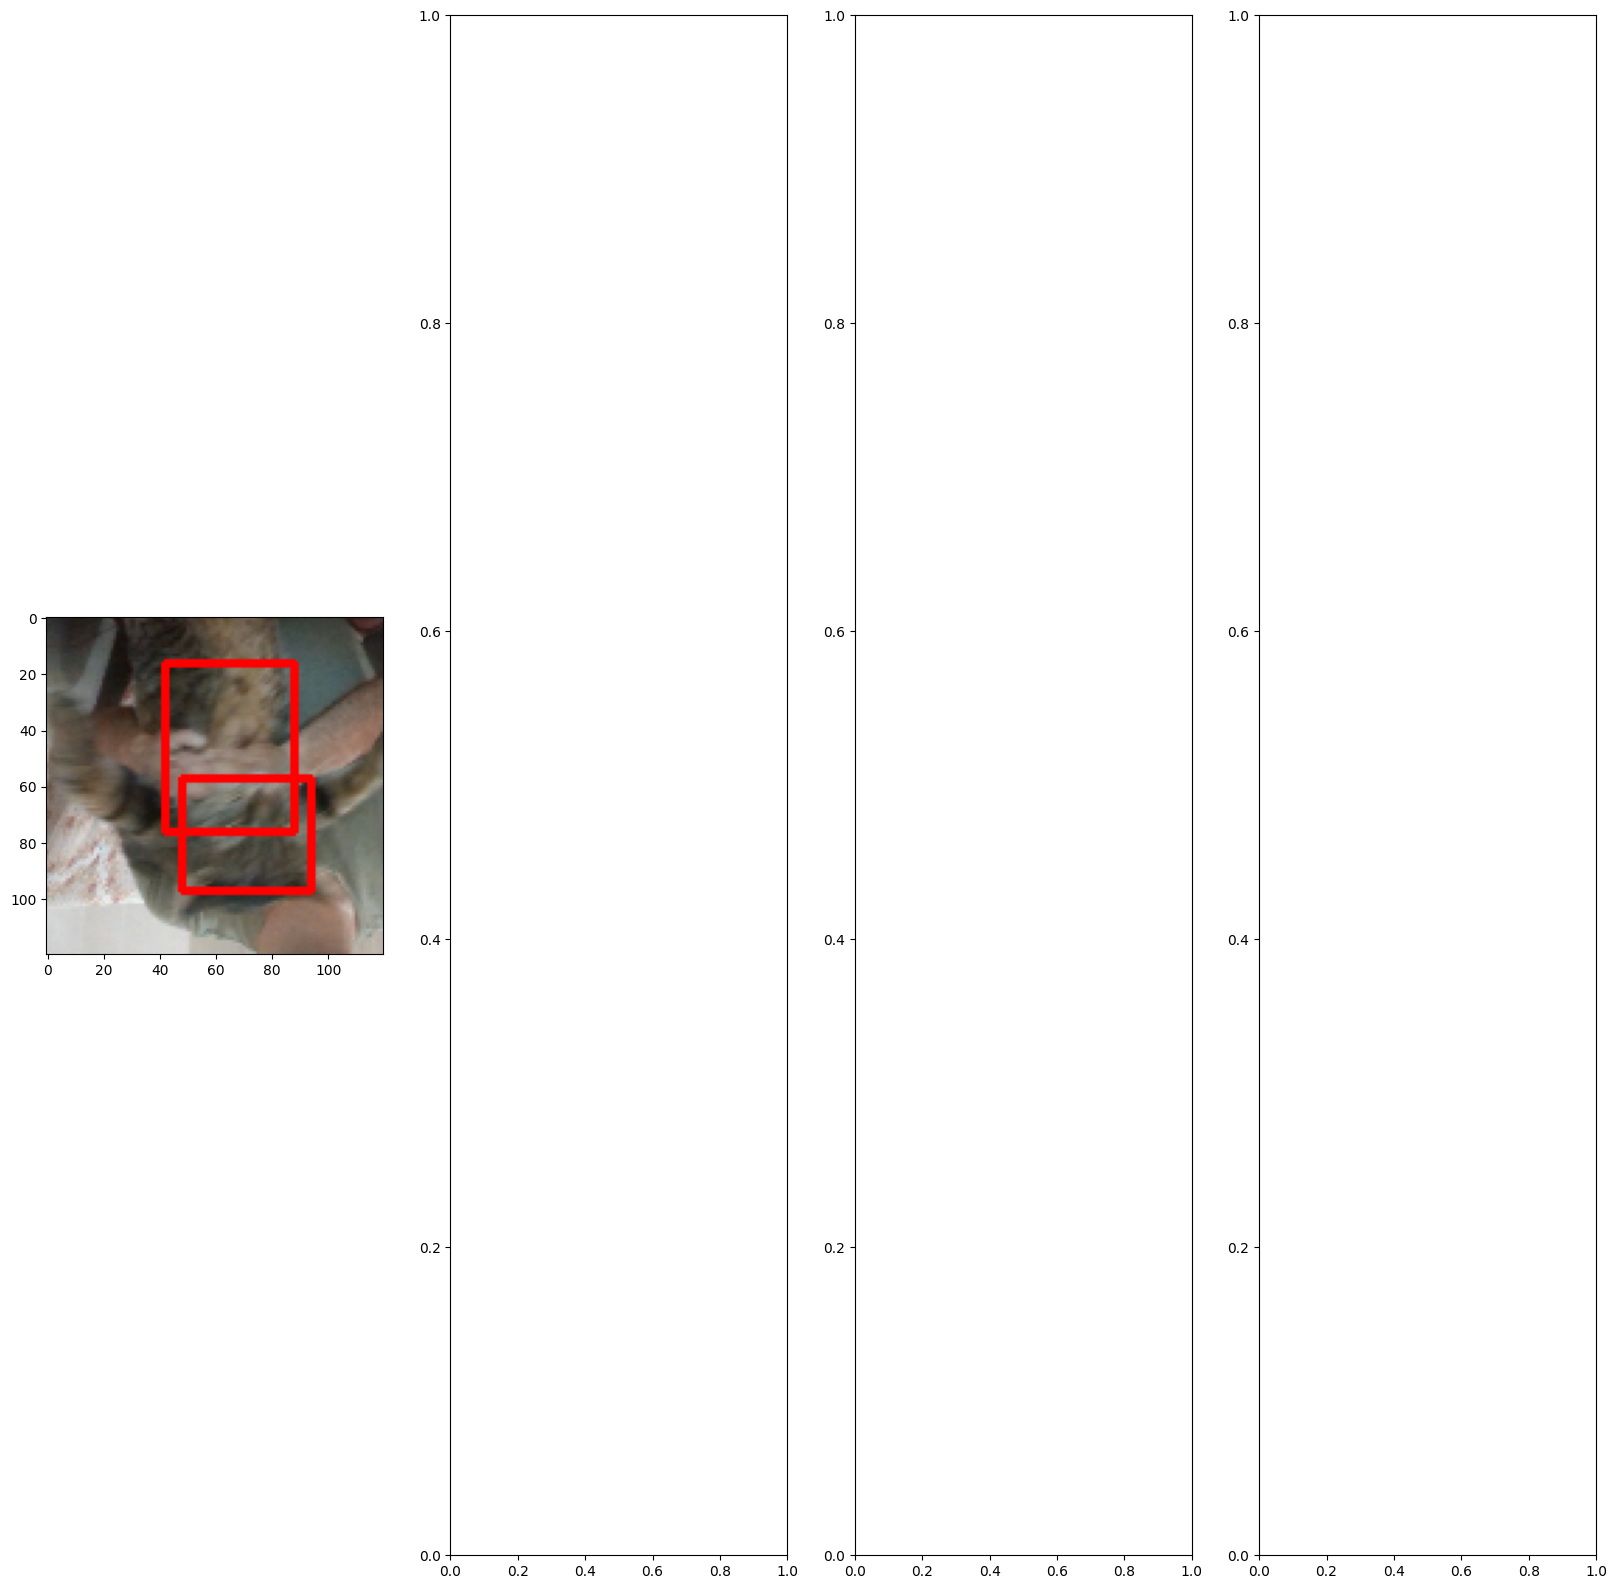

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

11.2 Save the Model

In [80]:
from tensorflow.keras.models import load_model

In [81]:
facetracker.save('facetracker.h5')

In [82]:
facetracker = load_model('facetracker.h5')

In [88]:
yhat

array([[0.3558244 , 0.13997477, 0.7384643 , 0.64128035]], dtype=float32)

In [89]:
yhat[1][0]

array([0.3558244 , 0.13997477, 0.7384643 , 0.64128035], dtype=float32)

In [90]:
yhat[0]

array([[0.99999994]], dtype=float32)

11.3 Real Time Detection

In [100]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.8: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
    
    cv2.imshow('Face', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 93ms/step
